Carga de módulos y aproximación al dataset

In [422]:
#Carga de módulos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import mannwhitneyu
import statsmodels.api as sm


In [423]:
'''
Carga del dataset 'export' descargado de meteostat.net bajo los siguientes parámetros:
Estación: Buenos Aires Observatorio
Rango de fechas: 13/11/2020 - 13/11/2025

Información de los campos:
date (YYYY-mm-dd)
tavg: average Temperature (°C)
tmin: minimum temperature (°C)
tmax: maximum temperature (°C)
prcp: total precipitation (mm)
snow: snow depth 
wdir: wind (From) direction (°)
wspd: wind speed (km/h)
wpgt: wind peak gust (km/h)
pres: sea-level air pressure (hPa)
tsun: total sunshine duration (minutes)
'''
df = pd.read_csv('export.csv')
df['date'] = pd.to_datetime(df['date'], origin='1899-12-30', unit='D')
df.head()



,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2020-11-13,22.2,19.2,26.6,NaN,NaN,NaN,9.0,NaN,1013.1,NaN
1,2020-11-14,22.2,19.3,26.6,NaN,NaN,NaN,4.0,NaN,1010.3,NaN
2,2020-11-15,20.9,15.7,26.0,NaN,NaN,NaN,11.1,NaN,1013.5,NaN
3,2020-11-16,20.5,14.0,26.3,NaN,NaN,NaN,6.8,NaN,1014.6,NaN
4,2020-11-17,23.4,17.7,27.7,NaN,NaN,NaN,8.2,NaN,1013.0,NaN


In [424]:
print('\nDescripción estadística:\n')
print(df.describe(include='all'))


Descripción estadística:

                                date         tavg         tmin         tmax  \
count                           1827  1827.000000  1827.000000  1827.000000   
mean   2023-05-14 23:59:59.999999744    18.746196    14.418993    24.374330   
min              2020-11-13 00:00:00     3.700000    -1.900000     9.200000   
25%              2022-02-12 12:00:00    14.100000     9.800000    19.400000   
50%              2023-05-15 00:00:00    18.900000    14.600000    24.400000   
75%              2024-08-13 12:00:00    23.400000    19.100000    29.400000   
max              2025-11-13 00:00:00    33.500000    29.800000    41.500000   
std                              NaN     5.840665     5.899633     6.260565   

              prcp      snow  wdir         wspd  wpgt         pres  tsun  
count  1318.000000  5.000000   0.0  1827.000000   0.0  1827.000000   0.0  
mean      3.986419  2.800000   NaN     8.743733   NaN  1015.985495   NaN  
min       0.000000  1.000000   NaN  


Valores faltantes por columna:

date       0
tavg       0
tmin       0
tmax       0
prcp     509
snow    1822
wdir    1827
wspd       0
wpgt    1827
pres       0
tsun    1827
dtype: int64


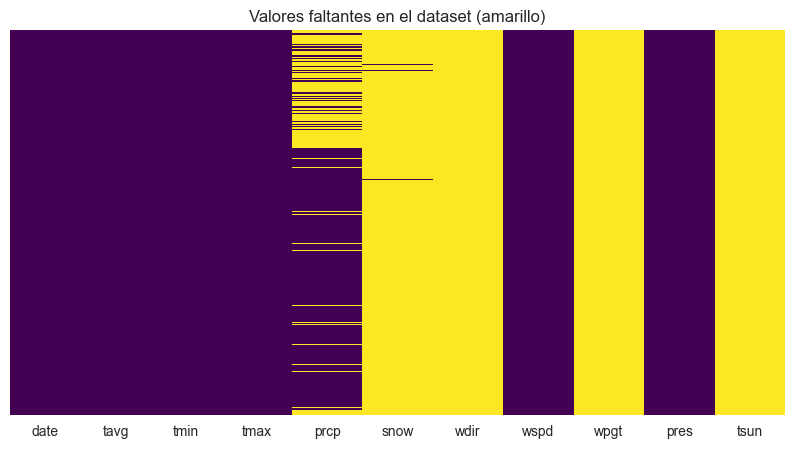

In [425]:
print('\nValores faltantes por columna:\n')
print(df.isna().sum())

plt.figure(figsize=(10,5))
sns.heatmap(df.isna(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Valores faltantes en el dataset (amarillo)')
plt.show()

Limpieza del dataset

In [426]:
'''
¿Hay campos que deban ser eliminados?
-wdir, wpgt y tsun no poseen valores no nulos.
-en wspd, snow y pres, los valores no nulos representan más del 60% del total y no aportan relevancia para el análisis pertinente.
'''
cols_to_drop=['snow', 'wdir','wspd','wpgt', 'pres','tsun']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

df.head()

,date,tavg,tmin,tmax,prcp
0,2020-11-13,22.2,19.2,26.6,NaN
1,2020-11-14,22.2,19.3,26.6,NaN
2,2020-11-15,20.9,15.7,26.0,NaN
3,2020-11-16,20.5,14.0,26.3,NaN
4,2020-11-17,23.4,17.7,27.7,NaN


Tratamiento de valores nulos

In [427]:
'''
Al llegar a nuestro campo principal de interés, precipitación, vemos que hay un elevado número de valores nulos.
¿Corresponden mayoritariamente a días sin lluvia o se tienen datos faltantes relevantes para el análisis?
Para determinarlo, se agrupó la precipitación por año (2021-2024) y contrastó con los datos del Observatorio Central Buenos Aires
'''

#Preparación del dataset con registros diarios. Creación de las columnas 'year' y 'rainy_day' (valor booleano, True para día con precipitación)

df['year'] =df['date'].dt.year
df['rainy_day'] = df['prcp']>0


df_review = df.groupby('year').agg(
    daily_mm = ('prcp','sum'),
    daily_rainy_days= ('rainy_day','sum'),
)

#Carga del dataset del OCBA con datos anuales.
ocba = pd.read_csv('ocba.csv')
ocba.rename(columns={'mm':'ocba_mm', 'days':'ocba_rainy_days'}, inplace=True)


#Inner join de ambos datasets.

df_merge = df_review.merge(ocba, left_on='year', right_on='year', how='inner')

'''
A continuación, se calcula el error relativo del dataset, tomando como fuente de verdad los datos anuales del OCBA.
Se considerará aceptable un error relativo de hasta +-5%. A partir de ese valor, el dataset deberá someterse a un análisis más exhaustivo para determinar su validez.
'''
df_merge['prcp_difference']=((df_merge['daily_mm']-df_merge['ocba_mm'])/df_merge['ocba_mm'])*100
df_merge['rainy_days_difference']=((df_merge['daily_rainy_days']-df_merge['ocba_rainy_days'])/df_merge['ocba_rainy_days'])*100

df_merge.head()


,year,daily_mm,daily_rainy_days,ocba_mm,ocba_rainy_days,prcp_difference,rainy_days_difference
0,2021,961.0,79,959.8,80,0.125026,-1.250000
1,2022,773.2,82,752.4,80,2.764487,2.500000
2,2023,912.5,112,954.0,111,-4.350105,0.900901
3,2024,1145.4,96,1161.7,93,-1.403116,3.225806


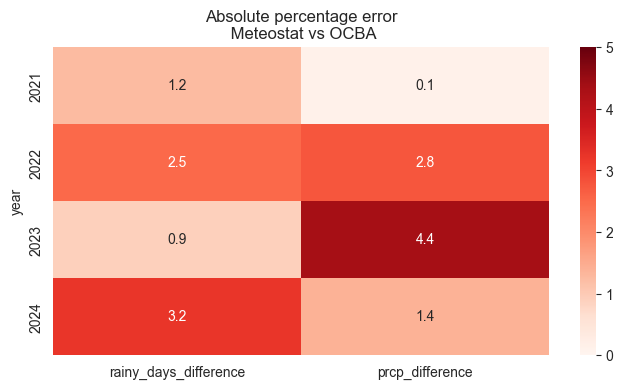

In [428]:
plt.figure(figsize=(8,4))
df_abs = df_merge.abs()
sns.heatmap(
    df_abs.set_index('year')[['rainy_days_difference', 'prcp_difference']],
    annot=True, fmt='.1f', cmap='Reds', vmin=0,vmax=5)
plt.title('Absolute percentage error\n Meteostat vs OCBA')
plt.show()

In [429]:
#Como se puede observar tanto analítica como gráficamente, el error relativo absoluto en ningún caso supera el 5%, por lo que es justificable reemplazar NaN por 0 mm
df['prcp'] = df['prcp'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1827 non-null   datetime64[ns]
 1   tavg       1827 non-null   float64       
 2   tmin       1827 non-null   float64       
 3   tmax       1827 non-null   float64       
 4   prcp       1827 non-null   float64       
 5   year       1827 non-null   int32         
 6   rainy_day  1827 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(4), int32(1)
memory usage: 80.4 KB


Detección de outliers

Valores por encima del percentil 99.5

            date   prcp
731  2022-11-14   90.5
1215 2024-03-12  127.0
1646 2025-05-17   98.0

Precipitaciones negativas

 Empty DataFrame
Columns: [date, prcp]
Index: []


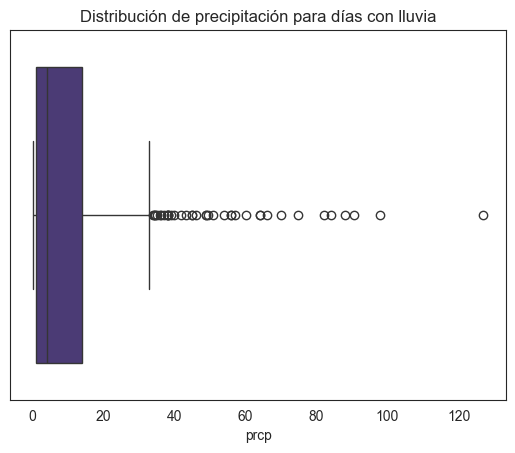

In [430]:
'''
La aparición de outliers puede afectar las conclusiones finales del análisis, por lo que se procede a detectar 
posibles valores atípicos de manera gráfica y analítica.
Dado que la naturaleza de una serie de precipitación posee un altísimo nivel de días con prcp =0, la distribución 
no es normal, es considerablemente asimétrica y con una cola larga, se analizará sólo los días con precipitación.

'''

sns.boxplot(x=df[df['rainy_day'] == True]['prcp'])
plt.title('Distribución de precipitación para días con lluvia')

#Valores por encima del percentil 99.5
p995 = df[df['rainy_day'] == True]['prcp'].quantile(0.995)
df_outliers = df.loc[df['prcp'] > p995, ['date', 'prcp']]
df_neg = df.loc[df['prcp'] < 0, ['date','prcp']]

print(f'Valores por encima del percentil 99.5\n\n {df_outliers}\n')
print(f'Precipitaciones negativas\n\n {df_neg}')



In [ ]:
'''
¿Qué conclusiones se pueden sacar de los resultados obtenidos?
Al analizar una variable meteorológica como precipitación, los valores típicos bien pueden ser días de lluvia intensa en lugar de errores.
En este caso, se compararon los tres días detectados con el registro del SMN en el sitio ogimet.com, encontrándo los mismos valores.

Valores inevitablemente erróneos serían, en este caso, valores negativos o mayores a 300 mm, el doble del récord histórico diario en Buenos Aires.
En este análisis, no se han encontrado ninguno de estos dos tipos de errores.
'''

Transformación del dataset

In [432]:
'''
Se crean campos para discriminar el registro por tipo de día de la semana:
day_of_week indica el número de día de la semana, comenzando por el índice 0 (lunes)
is_weekend es una variable booleana que retorna True para días viernes, sábado y domingo
'''


df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week']>3
df.head()



,date,tavg,tmin,tmax,prcp,year,rainy_day,day_of_week,is_weekend
0,2020-11-13,22.2,19.2,26.6,0.0,2020,False,4,True
1,2020-11-14,22.2,19.3,26.6,0.0,2020,False,5,True
2,2020-11-15,20.9,15.7,26.0,0.0,2020,False,6,True
3,2020-11-16,20.5,14.0,26.3,0.0,2020,False,0,False
4,2020-11-17,23.4,17.7,27.7,0.0,2020,False,1,False


Hypothesis testing

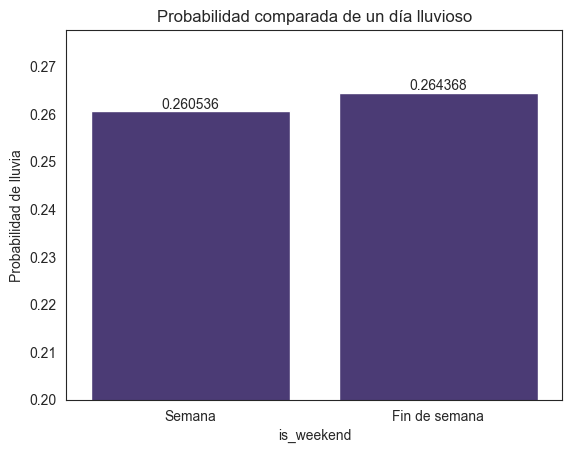

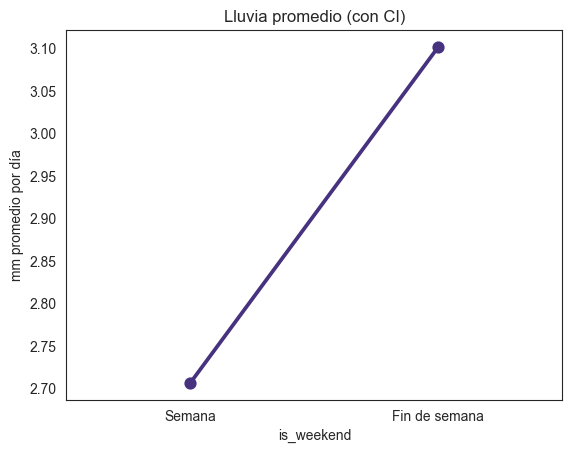

,prcp,rainy_days,total_days
is_weekend,,,
False,2.706418,0.260536,1044
True,3.101660,0.264368,783


In [433]:
'''
Es hora de testear nuestras dos preguntas:
1)¿Hay realmente más probabilidad de que llueva en el fin de semana que en el resto de los días?
2)¿En promedio, llueve más en el fin de semana que en el resto de los días?

Comencemos por agrupar nuestros datos y ver los resultados.
'''
prcp_by_weekday = df.groupby('is_weekend').agg(
    prcp = ('prcp', 'mean'),
    rainy_days = ('rainy_day', 'mean'),
    total_days = ('is_weekend', 'count')
)


ax = sns.barplot(
    data=prcp_by_weekday.reset_index(),
    x="is_weekend",
    y="rainy_days"
)
ax.set_ylim(bottom=0.20)
ax.bar_label(ax.containers[0])
plt.xticks([0,1], ["Semana", "Fin de semana"])
plt.ylabel("Probabilidad de lluvia")
plt.title("Probabilidad comparada de un día lluvioso")
plt.show()

sns.pointplot(
    data=prcp_by_weekday.reset_index(),
    x="is_weekend",
    y="prcp",
    capsize=0.2
)
plt.xticks([0,1], ["Semana", "Fin de semana"])
plt.ylabel("mm promedio por día")
plt.title("Lluvia promedio (con CI)")
plt.show()

prcp_by_weekday


¿Hay realmente más probabilidad de que llueva en el fin de semana que en el resto de los días?

In [434]:
'''
Podemos observar que, en Buenos Aires, llovió el 26.44% de los días de fines de semana en comparación con el 26.05% del resto de los días de la semana en los últimos 5 años.
Si bien 'a ojo' la diferencia porcentual parece pequeña, queremos determinar si es estadísticamente significativa.
Para ello, realizaremos la prueba de hipótesis indicada, que es la prueba Z de dos proporciones.
¿Qué evalúa un test Z de dos proporciones? Si hay una diferencia significativa en las proporciones de éxito entre dos grupos independientes.
En nuestro caso, los grupos son fines de semana (vie-dom) y días laborables (lun-jue)

Declaramos: 
Hipótesis nula (H0): la proporción de días con lluvias es la misma para fines de semana y días laborales.
Hipótesis alternativa (H1): la proporción de días lluviosos es diferente entre fines de semana y días laborales.
'''

#Comenzaremos el test creando dos Series booleanas determinando si un día es lluvioso y laboral (rain_weekday) o lluvioso y fin de semana (rain_weekend)
rain_weekday = df[df['is_weekend'] == False]['rainy_day']
rain_weekend = df[df['is_weekend'] == True]['rainy_day']

count = [rain_weekend.sum(), rain_weekday.sum()]  #es la cantidad de éxitos (lluvia) para ambos grupos
nobs = [len(rain_weekend), len(rain_weekday)]     #cantidad de días de cada grupo

z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
print('p-value para el test Z:', p_value)


p-value para el test Z: 0.8538041244079058


In [ ]:
''' 
El p-value es la probabilidad de obtener los resultados obtenidos en un estudio, asumiendo que la hipótesis nula es cierta. Para rechazar la hipótesis nula, 
el p-value debe ser menor o igual a 0.05. En este caso, un p-value de 0.8538 significa que hay un 85.38% de probabilidades de observar esta diferencia de proporciones si H0 es verdadera.
Es decir, no hay evidencia para rechazar H0, por lo que no se puede afirmar que la proporción de días lluviosos difiera entre días hábiles y fines de semana.
'''

¿En promedio, llueve más en el fin de semana que en el resto de los días?

In [436]:
''' 
Para responder a esta pregunta, compararemos las distribuciones de precipitaciones entre los dos grupos.
Dada la naturaleza de una distribución de precipitaciones (explicada previamente), el test a utilizar es el de Mann-Withney U.
Este test no paramétrico (no asume distribución normal) es el indicado para datos con abundancia de ceros y colas largas.

En este caso, declaramos:
Hipótesis nula (H0): No hay diferencia en la distribución de precipitación diaria entre fines de semana y días laborales.
Hipótesis alternativa (H1): hay diferencia en la distribución de precipitación diaria entre ambos grupos.
'''

#Creamos las series x e y para separar las precipitaciones en dos grupos
x = df[df["is_weekend"] == False]["prcp"]  # días laborales
y = df[df["is_weekend"] == True]["prcp"]   # fines de semana

#Realizamos el test
u_stat, p_value = mannwhitneyu(x, y, alternative='two-sided')

print("p-value:", p_value)

p-value: 0.61690366009889


In [ ]:
''' 
Con un p-value de 0.6170, no podemos rechazar H0. Es decir, no hay evidencia de que la diferencia en la precipitación diaria entre días laborales y fines de semana sea significativa estadísticamente.
'''

Conclusiones generales

In [ ]:
''' 
En este análisis, nos preguntamos si realmente había más chances de que llueva en un fin de semana que en la semana laboral. Para hacer más sólido el estudio, quisimos ver también si 
había diferencia en la intensidad de lluvia entre ambos grupos de días.
Para responder a estos interrogantes, realizamos los procesos clásicos de un análisis exploratorio de datos, como es el análisis de variables, la detección de outliers y su contexto,
el tratamiento de datos ausentes y la selección de variables relevantes.
Luego, establecimos formalmente nuestras hipótesis y realizamos el test estadístico pertinente.

En este caso, prevalecieron las hipótesis nulas para ambos casos, por lo que las diferencias encontradas entre ambos grupos no son significativas y se deben a la variabilidad natural 
el clima para el período 2020-2025 en la Ciudad de Buenos Aires.

Podemos decir que la apreciación de que llueve más probablemente cuando llega el fin de semana responde más a un sesgo cognitivo (nos son más significativos los días lluviosos que afectan los días libres de trabajo)
que a un patrón climatológico.
'''